In [275]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

from xgboost import XGBRegressor

#Load the CSV file
def load_airfoil_dataset(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)

    # Numeric geometry / Re fields
    num_cols = [
        "Re",
        "max_thickness",
        "x_at_max_thickness",
        "max_camber",
        "x_at_max_camber",
        "sharpness_rating",
        "radius_rating",
    ]

    for col in num_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    return df

csv_path = "airfoil_geometry_and_angel_of_stall_data.csv"  # adjust path/name if needed
df = load_airfoil_dataset(csv_path)

print("Raw shape:", df.shape)
df.head()


Raw shape: (4967, 11)


,airfoil_id,polar_id,Re,max_thickness,x_at_max_thickness,max_camber,x_at_max_camber,max_cl,alpha_at_max_cl,sharpness_rating,radius_rating
0,ag03-il,xf-ag03-il-100000,100000.0,0.046692,0.065,0.051173,0.281,1.0880,9.25,92.966907,7.033093
1,ag03-il,xf-ag03-il-1000000,1000000.0,0.046692,0.065,0.051173,0.281,1.3785,12.25,92.966907,7.033093
2,ag03-il,xf-ag03-il-200000,200000.0,0.046692,0.065,0.051173,0.281,1.1490,10.25,92.966907,7.033093
3,ag03-il,xf-ag03-il-50000,50000.0,0.046692,0.065,0.051173,0.281,1.0089,8.50,92.966907,7.033093
4,ag03-il,xf-ag03-il-500000,500000.0,0.046692,0.065,0.051173,0.281,1.2897,11.25,92.966907,7.033093


In [276]:
# Feature columns (7 parameters)
# Build X and Y (feature matrix and target output) 
FEATURE_COLS = [
    "Re",
    "max_thickness",
    "x_at_max_thickness",
    "max_camber",
    "x_at_max_camber",
    "sharpness_rating",
    "radius_rating",
]

# Stall angle column name (target)
STALL_COL = "max_cl"   # output

# 1) Clean stall-angle column: handle 'not reached' text etc.
df[STALL_COL] = (
    df[STALL_COL]
    .astype(str)        # ensure string for text replacement
    .str.strip()
    .replace(
        {
            "not reached": np.nan,
            "have not reached": np.nan,
            "Not reached": np.nan,
            "Have not reached": np.nan,
        }
    )
)

# 2) Convert stall-angle to numeric; anything non-numeric → NaN
df[STALL_COL] = pd.to_numeric(df[STALL_COL], errors="coerce")

# 3) Drop rows with missing values in ANY feature or in stall angle
df_clean = df.dropna(subset=FEATURE_COLS + [STALL_COL]).copy()

df_clean = df_clean[df_clean[STALL_COL] > 0.5]

print("After dropping NaNs (incl. 'not reached'):")
print("Clean shape:", df_clean.shape)

# 4) Build X (inputs) and y (target)
X = df_clean[FEATURE_COLS].values.astype(np.float32)
y = df_clean[STALL_COL].values.astype(np.float32)

print("X shape:", X.shape)
print("y shape:", y.shape)

df_clean[FEATURE_COLS + [STALL_COL]].head()


After dropping NaNs (incl. 'not reached'):
Clean shape: (4916, 11)
X shape: (4916, 7)
y shape: (4916,)


,Re,max_thickness,x_at_max_thickness,max_camber,x_at_max_camber,sharpness_rating,radius_rating,max_cl
0,100000.0,0.046692,0.065,0.051173,0.281,92.966907,7.033093,1.0880
1,1000000.0,0.046692,0.065,0.051173,0.281,92.966907,7.033093,1.3785
2,200000.0,0.046692,0.065,0.051173,0.281,92.966907,7.033093,1.1490
3,50000.0,0.046692,0.065,0.051173,0.281,92.966907,7.033093,1.0089
4,500000.0,0.046692,0.065,0.051173,0.281,92.966907,7.033093,1.2897


In [277]:
#Training and validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Test:  ", X_val.shape, y_val.shape)


Train: (3932, 7) (3932,)
Test:   (984, 7) (984,)


In [278]:
xgb_model = XGBRegressor(
    n_estimators=1600,      # number of trees
    max_depth=8,          # tree depth (controls complexity)
    learning_rate=0.03,   # step size for boosting
    subsample=0.9,        # row subsampling
    colsample_bytree=0.9, # feature subsampling per tree
    min_child_weight=3,
    reg_lambda=2.0,       # L2 regularization
    reg_alpha=0.3,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,            # use all CPU cores
)

#Cross-validation
scores = cross_val_score(
    xgb_model,
    X, y,
    cv=5,
    scoring="r2"
)
print("5-fold R² scores:", scores)
print("Mean R²:", scores.mean())
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_val)


5-fold R² scores: [0.28589231 0.3223151  0.41472256 0.31955498 0.09255338]
Mean R²: 0.28700766563415525


In [280]:
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2  = r2_score(y_val, y_pred)

print(f"XGBoost stall-angle MAE  (deg): {mae:.3f}")
print(f"XGBoost stall-angle RMSE (deg): {rmse:.3f}")
print(f"XGBoost stall-angle R²:         {r2:.3f}")


XGBoost stall-angle MAE  (deg): 0.100
XGBoost stall-angle RMSE (deg): 0.158
XGBoost stall-angle R²:         0.713


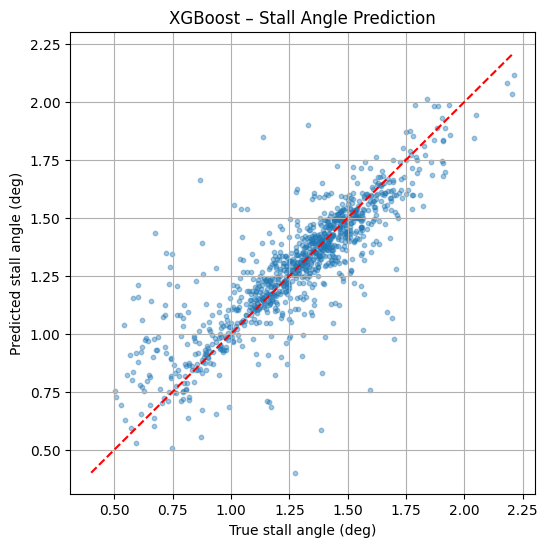

In [281]:
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred, s=10, alpha=0.4)
min_v = min(y_val.min(), y_pred.min())
max_v = max(y_val.max(), y_pred.max())
plt.plot([min_v, max_v], [min_v, max_v], "r--")
plt.xlabel("True stall angle (deg)")
plt.ylabel("Predicted stall angle (deg)")
plt.title("XGBoost – Stall Angle Prediction")
plt.grid(True)
plt.show()
